In [50]:
#pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host=files.pythonhosted.org jupyter-dash -q

In [51]:
#pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host=files.pythonhosted.org dash-cytoscape -q

In [52]:
# pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host=files.pythonhosted.org streamlit

In [53]:
#pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host=files.pythonhosted.org scikit-learn

In [54]:
#pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host=files.pythonhosted.org xgboost

In [55]:
#pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host=files.pythonhosted.org shap

In [56]:
"""
Created on Fri Dec 1 2023

@author: Naveen 
"""
import dash
from dash import dcc
from dash import html
import plotly.express as px
import pandas as pd
import numpy as np
import pickle
import streamlit as st
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [57]:
# Load dataset
df = pd.read_csv("C:/data/us_chronic_disease_indicators.csv")

In [58]:
#df.info()
#df.head(5)

In [59]:
# Create a copy of the original data to use in Streamlit app
df_original = df.copy()

In [60]:
# Exploratory Data Analysis - Dropping Redundant Columns, since the same information is already available
# Drop the columns that are not needed for prediction
df = df.drop(columns=["yearstart", "locationabbr", "datasource", "lowconfidencelimit", "highconfidencelimit", "geolocation", "topicid", "questionid", "datavaluetypeid", "stratificationid1", "stratificationcategory1"])
#df = df.drop(columns=["locationabbr", "datasource", "lowconfidencelimit", "highconfidencelimit", "geolocation", "topicid", "questionid", "datavaluetypeid", "stratificationid1", "stratificationcategory1"])
#df = df.drop(columns=["stratificationcategory1"])

In [61]:
#Apply filters create the model specific dataset
# Step 2: Filter data for the last decade (2010-2019)
#df['yearend'] = pd.to_datetime(df['yearend'], format='%Y')
#df = df[(df['yearend'] >= '2011-01-01') & (df['yearend'] <= '2020-12-31')]
df = df[(df.topic.isin(['Alcohol','Cardiovascular Disease', 'Chronic Kidney Disease', 'Chronic Obstructive Pulmonary Disease', 'Diabetes']))]

In [62]:
# Create Final Dataset for Mortality Prediction 
#result_case_insensitive = df[df['Column1'].str.contains('AN', case=False)]
#print(result_case_insensitive)
df_mortality = df[df['question'].str.contains('Mortality', case=False) 
#                  & df.stratificationcategoryid1.isin(['GENDER', 'OVERALL'])
                   & df.stratificationcategoryid1.isin([ 'OVERALL'])
                  & df.datavaluetype.isin(['Average Annual Number', 'Number'])
#                  & df.locationdesc.isin(['Michigan', 'Texas', 'California', 'Tennessee', 'Florida', 'New York', 'Ohio', 'Illinois', 'Pennsylvania'])
                  & df.locationdesc.isin(['Alabama', 'Arizona', 'Arkansas', 'Colorado', 'Delware', 'Connecticut', 'Georgia', 'Indiana'])
                 ]
df_mortality = df_mortality.drop(columns=['datavalueunit', 'datavaluetype','stratification1', 'stratificationcategoryid1'])

In [63]:
df_mortality.head(5)

,yearend,locationdesc,topic,question,datavalue
24,2014,Connecticut,Alcohol,Chronic liver disease mortality,375.0
1038,2014,Connecticut,Chronic Kidney Disease,Mortality with end-stage renal disease,2233.0
1119,2020,Alabama,Chronic Obstructive Pulmonary Disease,Mortality with chronic obstructive pulmonary d...,3346.0
1232,2013,Alabama,Chronic Obstructive Pulmonary Disease,Mortality with chronic obstructive pulmonary d...,5112.0
1234,2017,Alabama,Chronic Obstructive Pulmonary Disease,Mortality with chronic obstructive pulmonary d...,5248.0


In [64]:
df_mortality = df_mortality.drop(columns=['question'])

In [65]:
df_mortality['locationdesc'] = df['locationdesc'].astype(str)
df_mortality['topic'] = df['topic'].astype(str)
#df_mortality['question'] = df['question'].astype(str)
#df_mortality['datavaluetype'] = df['datavaluetype'].astype(str)
#df_mortality['stratification1'] = df['stratification1'].astype(str)
#df_mortality['stratificationcategoryid1'] = df['stratificationcategoryid1'].astype(str)
#df_mortality = df_mortality.drop(columns=['datavalue', 'datavaluetype','stratification1', 'stratificationcategoryid1'])
#df_mortality['yearend'] = (df_mortality['yearend'] - df_mortality['yearend'].min()).dt.days
#df_mortality.info()

In [66]:
df_mortality = df_mortality.groupby(['yearend', 'locationdesc', 'topic'] )['datavalue'].sum().reset_index()

In [67]:
df_mortality.head(20)

,yearend,locationdesc,topic,datavalue
0,2010,Alabama,Alcohol,504.0
1,2010,Alabama,Cardiovascular Disease,41832.0
2,2010,Alabama,Chronic Kidney Disease,4359.0
3,2010,Alabama,Chronic Obstructive Pulmonary Disease,7516.0
4,2010,Alabama,Diabetes,3967.0
5,2010,Arizona,Alcohol,870.0
6,2010,Arizona,Cardiovascular Disease,36679.0
7,2010,Arizona,Chronic Kidney Disease,3386.0
8,2010,Arizona,Chronic Obstructive Pulmonary Disease,7626.0
9,2010,Arizona,Diabetes,2793.0


In [68]:
# 'datavalue' is the Target Variable
# Create a copy of the original data to use in Streamlit app
df_mortality_original = df_mortality.copy()
y = df_mortality['datavalue']
X = df_mortality.drop(columns=['datavalue'])
y = y.astype(int)

In [69]:
# Convert categorical features into numeric by encoding the categories
label_encoders = {}
for column in X.columns:
    if X[column].dtype == type(object):
        le = LabelEncoder()
        X[column] = le.fit_transform(X[column].astype(str))
        label_encoders[column] = le

In [70]:
X_train

,yearend,locationdesc,topic
165,2014,5,0
322,2019,1,2
220,2016,2,0
94,2012,4,4
232,2016,4,2
...,...,...,...
71,2012,0,1
106,2013,0,1
270,2017,5,0
348,2019,6,3


In [71]:
X_test

,yearend,locationdesc,topic
268,2017,4,3
250,2017,1,0
355,2020,1,0
332,2019,3,2
56,2011,4,1
...,...,...,...
104,2012,6,4
167,2014,5,2
63,2011,5,3
233,2016,4,3


In [72]:
y_train

165      935
322     3695
220      416
94      1916
232     2360
       ...  
71     41394
106    42636
270     1146
348    14056
102     7260
Name: datavalue, Length: 308, dtype: int32

In [73]:
y_test

268     4201
250     1137
355     1431
332     3758
56     25275
       ...  
104     5819
167     5257
63     10080
233     4049
84      2457
Name: datavalue, Length: 77, dtype: int32

In [74]:
#class_mapping = {class_label: idx for idx, class_label in enumerate(sorted(y_train.unique()))}
#y_train = y_train.map(class_mapping)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_pred = linear_model.predict(X_test)

# Fit a Lasso regression model
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)


# Fit a random forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Fit an XGBoost model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# Calculate mean squared error for each model
linear_mse = mean_squared_error(y_test, linear_pred)
ridge_mse = mean_squared_error(y_test, ridge_pred)
rf_mse = mean_squared_error(y_test, rf_pred)
xgb_mse = mean_squared_error(y_test, xgb_pred)


# Calculate Root mean squared error for each model
linear_rmse = np.sqrt(linear_mse)
ridge_rmse = np.sqrt(ridge_mse)
rf_rmse = np.sqrt(rf_mse)
xgb_rmse = np.sqrt(xgb_mse)


# Calculate R-squared (R2) for each model
linear_r2 = r2_score(y_test, linear_pred)
ridge_r2 = r2_score(y_test, ridge_pred)
rf_r2 = r2_score(y_test, rf_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

# Print the metric results to asses the model's ability to predict continous values.
print(f"Linear regression MSE, RMSE & R2: {linear_mse} , {linear_rmse} & {linear_r2} ")
print(f"Lasso regression MSE, RMSE & R2: {ridge_mse} , {ridge_rmse} & {ridge_r2} ")
print(f"Random forest MSE, RMSE & R2: {rf_mse} , {rf_rmse} & {rf_r2} ")
print(f"XGBoost MSE, RMSE & R2: {xgb_mse} , {xgb_rmse} & {xgb_r2} ")

Linear regression MSE, RMSE & R2: 270911938.6649245 , 16459.402743262726 & 0.03460884396466013 
Lasso regression MSE, RMSE & R2: 270910938.320174 , 16459.372354988933 & 0.034612408680116724 
Random forest MSE, RMSE & R2: 1037577.4258818168 , 1018.615445534681 & 0.9963026063909013 
XGBoost MSE, RMSE & R2: 1290688.8907011477 , 1136.0848959039758 & 0.9954006469909874 


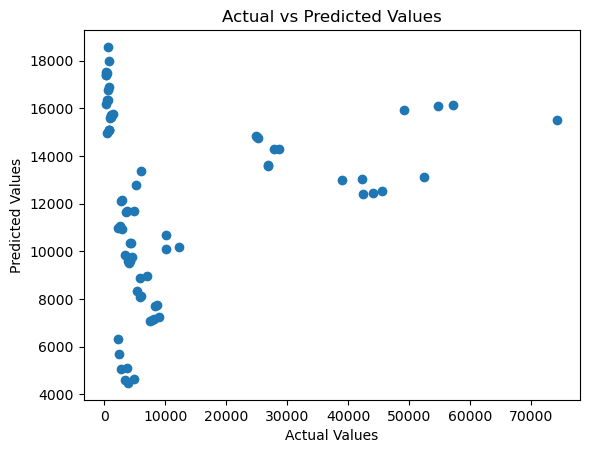

In [75]:
# Visualize predicted vs actual values (Linear Regression)
plt.scatter(y_test, linear_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

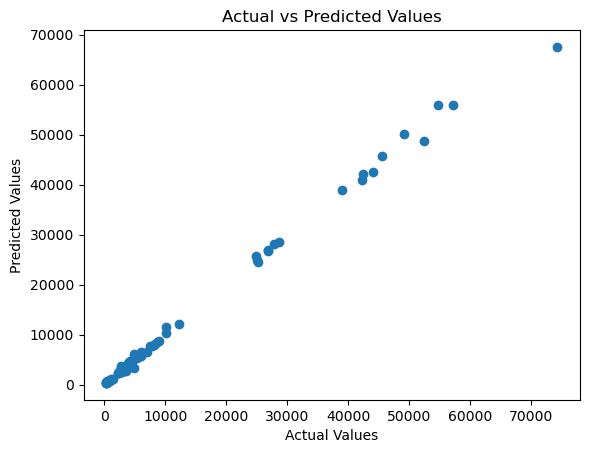

In [76]:
# Visualize predicted vs actual values (Random Forest model)
plt.scatter(y_test, rf_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

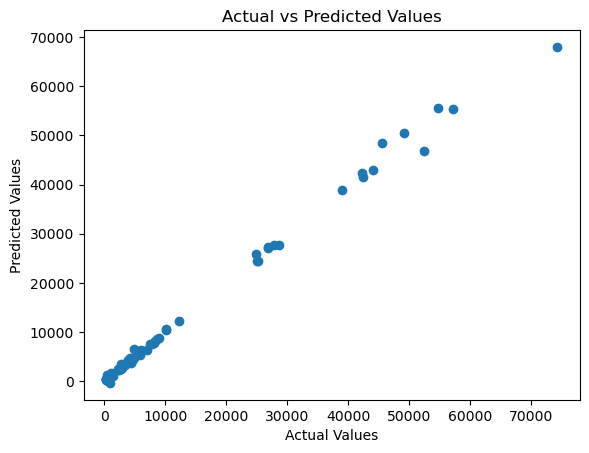

In [77]:
# Visualize predicted vs actual values (XGBoost model)
plt.scatter(y_test, xgb_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

In [78]:
print("Number of samples in X_train:", len(X_train))
print("Number of samples in y_train:", len(y_train))

Number of samples in X_train: 308
Number of samples in y_train: 308


In [79]:
linear_model.intercept_

-21054.854510005516

In [80]:
y_pred = linear_model.predict(X_train)
residuals = y_train - y_pred

In [81]:
sum(residuals)/len(residuals) # mean residual

2.0197869351061135e-12

In [82]:
max(residuals), min(residuals)

(53110.81195973714, -17914.42894326474)

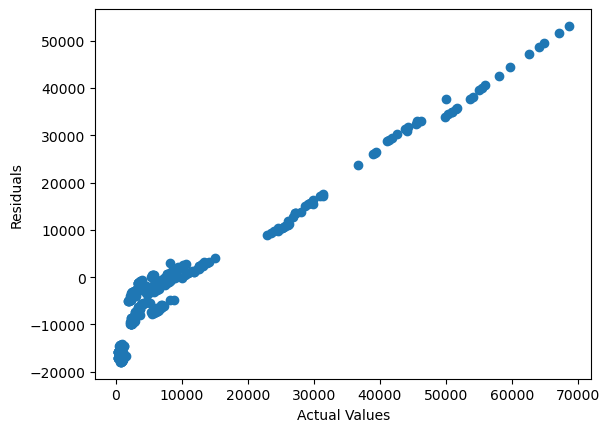

In [83]:
#Residuals plot for Linear Regression
import matplotlib.pyplot as plt
plt.scatter(y_train, residuals)
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()

In [84]:
y_pred2 = rf_model.predict(X_train)
residuals = y_train - y_pred2

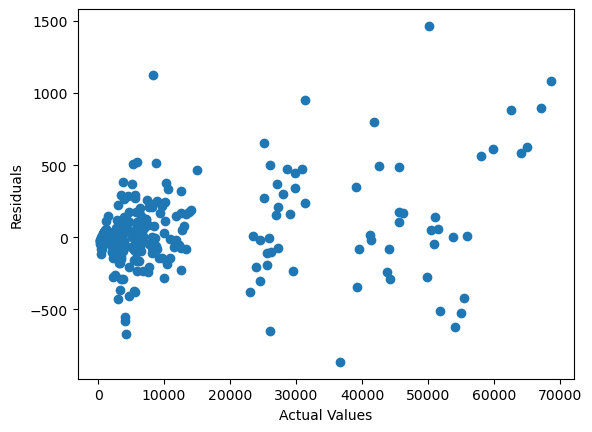

In [85]:
#Residuals plot for Random Forest Regression
import matplotlib.pyplot as plt
plt.scatter(y_train, residuals)
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()

In [86]:
y_pred1 = xgb_model.predict(X_train)
residuals = y_train - y_pred1

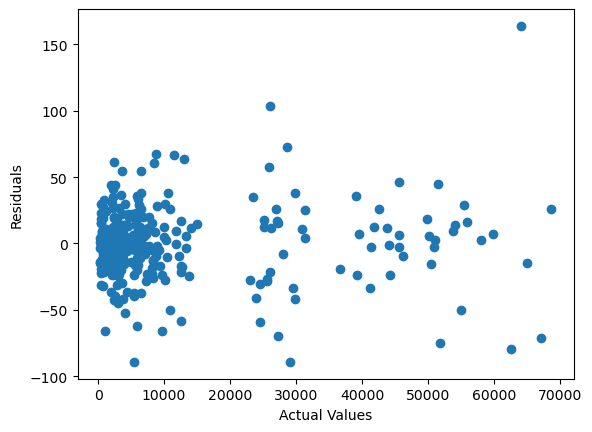

In [87]:
#Residuals plot for Xgb Regression
import matplotlib.pyplot as plt
plt.scatter(y_train, residuals)
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()

In [88]:
# Save the trained model and the label encoders to disk for later use in the Streamlit app
with open('model.pkl', 'wb') as f:
    pickle.dump(linear_model, f)
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)
with open('columns_order.pkl', 'wb') as f:
    pickle.dump(X_train.columns.tolist(), f)

In [89]:
# Load the saved model and label encoders
with open('model.pkl', 'rb') as f:
    linear_model = pickle.load(f)
with open('rf_model.pkl', 'rb') as f:
    rf_model = pickle.load(f)
with open('label_encoders.pkl', 'rb') as f:
    label_encoders = pickle.load(f)
with open('columns_order.pkl', 'rb') as f:
    columns_order = pickle.load(f) 

In [90]:
# Function to make predictions 
def predict_mortality_data(mortality_data):
    # Convert mortality data into the same format as the training data
    for col, value in mortality_data.items():
        if col in label_encoders:  # for categorical data
            le = label_encoders[col]
            if value in le.classes_:
                mortality_data[col] = le.transform([value])[0]
            else:
                mortality_data[col] = le.transform([le.classes_[0]])[0]  # if value is not in classes, use the first class
        else:  # for numerical data
            mortality_data[col] = float(value)

    # Convert patient data into dataframe
    df = pd.DataFrame([mortality_data])
    df = df[columns_order]
    
    # Predict the Mortality Avg Number for selected disease
    mor = linear_model.predict(df)
    return mor

In [91]:
# Function to make predictions 
def predict_mortality_data_rid(mortality_data):
    # Convert mortality data into the same format as the training data
    for col, value in mortality_data.items():
        if col in label_encoders:  # for categorical data
            le = label_encoders[col]
            if value in le.classes_:
                mortality_data[col] = le.transform([value])[0]
            else:
                mortality_data[col] = le.transform([le.classes_[0]])[0]  # if value is not in classes, use the first class
        else:  # for numerical data
            mortality_data[col] = float(value)

    # Convert patient data into dataframe
    df = pd.DataFrame([mortality_data])
    df = df[columns_order]
    
    # Predict the Mortality Avg Number for selected disease
    mor_rid = ridge_model.predict(df)
    return mor_rid

In [92]:
# Function to make predictions 
def predict_mortality_data_rf(mortality_data):
    # Convert mortality data into the same format as the training data
    for col, value in mortality_data.items():
        if col in label_encoders:  # for categorical data
            le = label_encoders[col]
            if value in le.classes_:
                mortality_data[col] = le.transform([value])[0]
            else:
                mortality_data[col] = le.transform([le.classes_[0]])[0]  # if value is not in classes, use the first class
        else:  # for numerical data
            mortality_data[col] = float(value)

    # Convert patient data into dataframe
    df = pd.DataFrame([mortality_data])
    df = df[columns_order]
    
    # Predict the Mortality Avg Number for selected disease
    mor_rf = rf_model.predict(df)
    return mor_rf

In [93]:
# Function to make predictions 
def predict_mortality_data_xgb(mortality_data):
    # Convert mortality data into the same format as the training data
    for col, value in mortality_data.items():
        if col in label_encoders:  # for categorical data
            le = label_encoders[col]
            if value in le.classes_:
                mortality_data[col] = le.transform([value])[0]
            else:
                mortality_data[col] = le.transform([le.classes_[0]])[0]  # if value is not in classes, use the first class
        else:  # for numerical data
            mortality_data[col] = float(value)

    # Convert patient data into dataframe
    df = pd.DataFrame([mortality_data])
    df = df[columns_order]
    
    # Predict the Mortality Avg Number for selected disease
    mor_xgb = xgb_model.predict(df)
    return mor_xgb

In [94]:
# Use Streamlit to create the UI
st.title('US Disease - Mortality Rate Prediction')

DeltaGenerator()

In [95]:
# Create inputs for all the features
mortality_data = {}

In [96]:
for feature_name, le in label_encoders.items():
    options = list(le.classes_)  # Get the list of classes seen during training
    mortality_data[feature_name] = st.selectbox(f"Select {feature_name}", options)

In [97]:
numeric_cols = ['yearend']
for col in numeric_cols:
    mortality_data[col] = st.number_input(f"Enter {col}", step=1)  # Use a suitable step size

In [98]:
# Button for making prediction
if st.button('Predict Mortality Avg Number'):
    prediction_mor = predict_mortality_data(mortality_data)
    prediction_mor_rf = predict_mortality_data_rf(mortality_data)
    prediction_mor_xgb = predict_mortality_data_xgb(mortality_data)
    prediction_mor_rid = predict_mortality_data_rid(mortality_data)
    #st.text(prediction_mor)
    st.write(f'Mortality Rate for the diseases using Linear Regression is {int(prediction_mor)}')
    st.write(f'Mortality Rate for the diseases using Ridge Regression is {int(prediction_mor_rid)}')
    st.write(f'Mortality Rate for the diseases using Random Forest is {int(prediction_mor_rf)}')
    st.write(f'Mortality Rate for the diseases using Xgb Boost is {int(prediction_mor_xgb)}')